In [1]:
import sys
from pathlib import Path
base_dir = str(Path(sys.path[0]) / "..")
sys.path.insert(0, base_dir)
print(sys.path)

['/home/user/kew/projects/understanding-ctx-aug/analysis/..', '/home/user/kew/projects/understanding-ctx-aug/analysis', '/home/user/kew/anaconda3/envs/ctx_aug_24/lib/python38.zip', '/home/user/kew/anaconda3/envs/ctx_aug_24/lib/python3.8', '/home/user/kew/anaconda3/envs/ctx_aug_24/lib/python3.8/lib-dynload', '', '/home/user/kew/anaconda3/envs/ctx_aug_24/lib/python3.8/site-packages', '/home/user/kew/projects/understanding-ctx-aug/src/transformers/src']


In [2]:
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer
from collections import Counter
from typing import List
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy.stats import pearsonr, linregress
from scipy.spatial.distance import pdist, cdist, dice, hamming, jaccard
import matplotlib.pyplot as plt
from data import preprocess_topical_chat_dataset, preprocess_function, load_data, prepare_data_for_model
from pprint import pprint
from evaluation.sentiment import classify_sentiment_with_vader, parse_vader_result, classify_sentiment
from evaluation.sentence_processing import count_questions


/home/user/kew/anaconda3/envs/ctx_aug_24/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# tokenizer = AutoTokenizer.from_pretrained('../resources/models/seed_23/pt/hf_conv/bart_small-SI_t5/')
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

In [4]:
def load_json_dataset(dataset: Path):   
    split = dataset.stem
    extension = dataset.suffix.strip('.')
    print(split, extension, str(dataset))
    dataset_dict = load_dataset(extension, data_files={'test': str(dataset)})
    return dataset_dict # concatenate_datasets(loaded_datasets)

def tokenize_dataset(dataset):
    dataset = dataset.map(
    preprocess_topical_chat_dataset,
    batched=True,
    num_proc=4,
    desc="Running tokenizer on dataset",
    fn_kwargs={
        'tokenizer': tokenizer,
        'speaker_id_tag': '<speaker_1>',
        'text_column': 'turns',
        'summary_column': 'target',
        'knowledge_column': 'knowledge',
        'knowledge_bucket_size': 32,
        'history_bucket_size': 25,
        'max_target_length': 128,
        'source_prefix': None,
        'pad_to_max_length': False,
        'ignore_pad_token_for_loss': False,
        },
    )
    
    return dataset

def flatten(l: List[List]) -> List:
    """flattens a list of lists"""
    return [item for sublist in l for item in sublist]

def get_vocab_stats(dataset, tokenizer=tokenizer):
    inputs_tokenized = list(map(tokenizer.convert_ids_to_tokens, dataset['test']['input_ids']))
    targets_tokenized = list(map(tokenizer.convert_ids_to_tokens, dataset['test']['labels']))

    print('inputs:')
    print(inputs_tokenized[:2], '...')
    print('targets:')
    print(targets_tokenized[:2], '...')

    input_vocab = Counter(flatten(inputs_tokenized))
    target_vocab = Counter(flatten(targets_tokenized))
    total_vocab = input_vocab + target_vocab

    print(f'Input vocab items: {len(input_vocab)}')
    print(f'Target vocab items: {len(target_vocab)}')
    print(f'Combined vocab items: {len(total_vocab)}')
    print(f'Most common tokens: {total_vocab.most_common(20)}')

    df = pd.DataFrame.from_dict(total_vocab, orient='index').reset_index()
    df = df.rename(columns={'index':'token', 0:'freq_count'})
    
    return df

In [5]:
import re

def remove_speaker_ids(text):
    text = re.sub(r'<speaker[0-9]>', '', text)
    return text

def preprocess(example):
    # tokenize the list of turns
    turns = example["turns"]
    turns = [remove_speaker_ids(turn) for turn in turns]
    # get length of non-padded tokens
    example["turns_length"] = tokenizer(turns, padding=True, return_tensors='np')['attention_mask'].sum()

    # example["turns_length"] = sum(t for t in turns["attention_mask"])

    # get length of non-padded tokens
    if "knowledge" in example:
        example["knowledge_length"] = tokenizer(example["knowledge"], return_tensors='np')["attention_mask"].sum()
    elif "context" in example:
        example["knowledge_length"] = tokenizer(example["context"], return_tensors='np')["attention_mask"].sum()
    else:
        example["knowledge_length"] = 0

    # get length of non-padded tokens
    example["target_length"] = tokenizer(example["target"], return_tensors='np')["attention_mask"].sum()

    return example

def preprocess_turns_finegrained(example):
    # tokenize the list of turns
    turns = example["turns"]
    turns = [remove_speaker_ids(turn) for turn in turns]
    # get length of non-padded tokens
    # example["turns_length"] = tokenizer(turns, padding=True, return_tensors='np')['attention_mask'].sum()

    
    example["turns_length"] = []
    for turn in turns:
        example["turns_length"].append(tokenizer(turn, return_tensors='np')['attention_mask'].sum())
    # example["turns_length"] = sum(t for t in turns["attention_mask"])

    # get length of non-padded tokens
    if "knowledge" in example:
        example["knowledge_length"] = tokenizer(example["knowledge"], return_tensors='np')["attention_mask"].sum()
    elif "context" in example:
        example["knowledge_length"] = tokenizer(example["context"], return_tensors='np')["attention_mask"].sum()
    else:
        example["knowledge_length"] = 0

    # get length of non-padded tokens
    example["target_length"] = tokenizer(example["target"], return_tensors='np')["attention_mask"].sum()

    return example



test_freq json ../resources/data/Topical-Chat/KGD/test_freq.json


Using custom data configuration default-dde5054e7562460d
Reusing dataset json (/home/user/kew/.cache/huggingface/datasets/json/default-dde5054e7562460d/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
Running tokenizer on dataset: 100%|██████████| 9065/9065 [00:07<00:00, 1207.16ex/s]


test_freq
45325
Mean turns length: 26.387468284611142
Median turns length: 24.0
Max turns length: 101
Min turns length: 3


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb93e4558e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb93e455e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb93e455610>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb939dd3460>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb939dd3730>],
 'means': []}

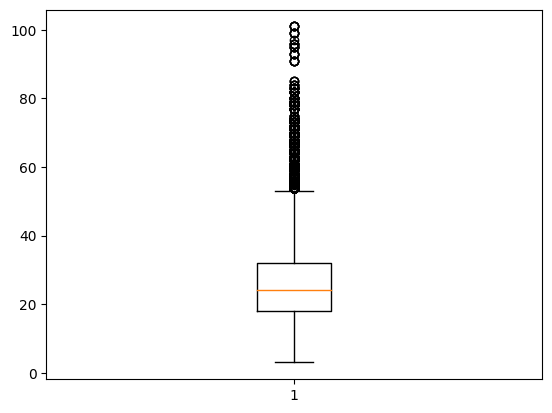

In [6]:
for split in ['test_freq']:
    d = load_json_dataset(Path(f'../resources/data/Topical-Chat/KGD/{split}.json'))
    d = d.map(preprocess_turns_finegrained, batched=False, num_proc=1, desc="Running tokenizer on dataset")
    print(split)

# flatten d['test']['turns_length'] into a single list
turns_lengths = [item for sublist in d['test']['turns_length'] for item in sublist]
print(len(turns_lengths))
print(f"Mean turns length: {np.mean(turns_lengths)}")
print(f"Median turns length: {np.median(turns_lengths)}")
print(f"Max turns length: {np.max(turns_lengths)}")
print(f"Min turns length: {np.min(turns_lengths)}")

# plot box and whisker plot
plt.boxplot(turns_lengths)

In [6]:

# Topical Chat
for split in ['train', 'valid_freq', 'test_freq', 'test_rare']:
    d = load_json_dataset(Path(f'../resources/data/Topical-Chat/KGD/{split}.json'))
    d = d.map(preprocess, batched=False, num_proc=1, desc="Running tokenizer on dataset")
    print(split)
    print(f"{np.array(d['test']['knowledge_length']).mean():.2f} +/- {np.array(d['test']['knowledge_length']).std():.2f}")
    print(f"{np.array(d['test']['turns_length']).mean():.2f} +/- {np.array(d['test']['turns_length']).std():.2f}")
    print(f"{np.array(d['test']['target_length']).mean():.2f} +/- {np.array(d['test']['target_length']).std():.2f}")
    print()



train json ../resources/data/Topical-Chat/KGD/train.json


Using custom data configuration default-7c84b0d4f047979e


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 229.75it/s]


Dataset json downloaded and prepared to /home/user/kew/.cache/huggingface/datasets/json/default-7c84b0d4f047979e/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


Running tokenizer on dataset: 100%|██████████| 145238/145238 [03:52<00:00, 624.35ex/s]


train
26.60 +/- 17.33
133.03 +/- 39.61
31.25 +/- 12.22

valid_freq json ../resources/data/Topical-Chat/KGD/valid_freq.json


Using custom data configuration default-17a4183d80a8691e


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 317.53it/s]


Dataset json downloaded and prepared to /home/user/kew/.cache/huggingface/datasets/json/default-17a4183d80a8691e/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


Running tokenizer on dataset: 100%|██████████| 8986/8986 [00:15<00:00, 588.98ex/s]


valid_freq
33.25 +/- 19.03
134.16 +/- 38.61
31.62 +/- 12.12

test_freq json ../resources/data/Topical-Chat/KGD/test_freq.json


Using custom data configuration default-dde5054e7562460d


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 321.53it/s]


Dataset json downloaded and prepared to /home/user/kew/.cache/huggingface/datasets/json/default-dde5054e7562460d/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


Running tokenizer on dataset: 100%|██████████| 9065/9065 [00:14<00:00, 607.85ex/s]


test_freq
29.07 +/- 17.65
131.94 +/- 37.42
31.16 +/- 11.97

test_rare json ../resources/data/Topical-Chat/KGD/test_rare.json


Using custom data configuration default-ec2db4f48d143b54


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 278.27it/s]


Dataset json downloaded and prepared to /home/user/kew/.cache/huggingface/datasets/json/default-ec2db4f48d143b54/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


Running tokenizer on dataset: 100%|██████████| 9075/9075 [00:15<00:00, 603.86ex/s]


test_rare
28.50 +/- 17.07
133.94 +/- 40.25
31.38 +/- 12.39



In [7]:
# for split in ['train']:
d = load_json_dataset(Path(f'../resources/data/Topical-Chat/KGD/{split}.json'))
d = d.map(preprocess, batched=False, num_proc=1, desc="Running tokenizer on dataset")
d

train json ../resources/data/Topical-Chat/KGD/train.json


Using custom data configuration default-7c84b0d4f047979e
Reusing dataset json (/home/user/kew/.cache/huggingface/datasets/json/default-7c84b0d4f047979e/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
Running tokenizer on dataset: 100%|██████████| 145238/145238 [03:51<00:00, 627.61ex/s]


DatasetDict({
    test: Dataset({
        features: ['turns', 'knowledge', 'target', 'turns_length', 'knowledge_length', 'target_length'],
        num_rows: 145238
    })
})

In [8]:
# analyse the sentiment distribution in the training data
sentiments = classify_sentiment_with_vader(d['test']['target'])


In [12]:
sentiments[:2]

[{'label': 'POSITIVE', 'score': 0.4588},
 {'label': 'NEGATIVE', 'score': -0.2732}]

In [13]:
sentiment_df = pd.DataFrame(sentiments)
sentiment_df

,label,score
0,POSITIVE,0.4588
1,NEGATIVE,-0.2732
2,POSITIVE,0.4576
3,POSITIVE,0.5574
4,POSITIVE,0.2023
...,...,...
145233,NEGATIVE,-0.2026
145234,POSITIVE,0.2960
145235,NEGATIVE,-0.4019
145236,POSITIVE,0.8519


<AxesSubplot:>

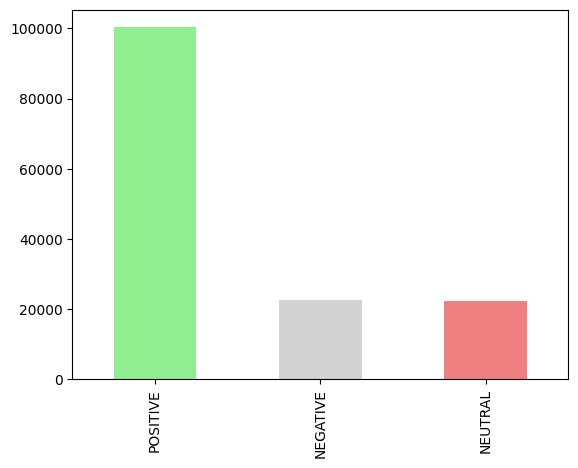

In [33]:
# create colorpalette with lightgreen, grey, lightcoral
color_palette = ['lightgreen', 'lightgrey', 'lightcoral']
sentiment_df['label'].value_counts().plot(kind='bar', color=color_palette)

Text(0.5, 1.0, 'Sentiment Distribution of Target Sentences\nin Topical Chat KGD Training Set')

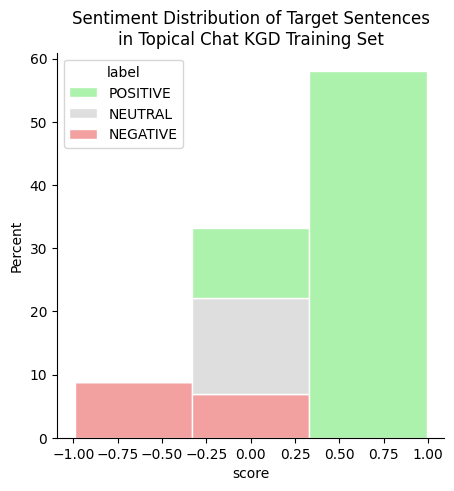

In [48]:
import seaborn as sns
# plot the sentiment distribution of positive, negative and neutral sentiments
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax = sns.histplot(
#     sentiment_df, 
#     x='label', 
#     hue='label', 
#     bins=3, 
#     kde=True, 
#     ax=ax, 
#     hue_order=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], 
#     # colors=['lightgreen', 'yellow', 'lightcoral']
#     )

ax = sns.histplot(
    sentiment_df, 
    x='score', 
    hue='label', 
    bins=3, 
    # kde=True, 
    ax=ax, 
    hue_order=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], 
    multiple="stack",
    stat="percent",
    palette=color_palette,
    # line_kws={'linewidth': 2}
    # hist_kws=dict(edgecolor="k", linewidth=2),
    edgecolor='w'
    # colors=['lightgreen', 'yellow', 'lightcoral']
    )

# hide splines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Sentiment Distribution of Target Sentences\nin Topical Chat KGD Training Set')


In [ ]:

# CSD
for split in ['train', 'valid', 'test']:
    d = load_json_dataset(Path(f'../resources/data/Commonsense-Dialogues/CSD/{split}.json'))
    d = d.map(preprocess, batched=False, num_proc=1, desc="Running tokenizer on dataset")
    print(split)
    print(rf"${np.array(d['test']['knowledge_length']).mean():.2f}_{{\pm {np.array(d['test']['knowledge_length']).std():.2f}}}$ & ${np.array(d['test']['turns_length']).mean():.2f}_{{\pm {np.array(d['test']['turns_length']).std():.2f}}}$ & ${np.array(d['test']['target_length']).mean():.2f}_{{\pm {np.array(d['test']['target_length']).std():.2f}}}$")
    print()


# DD
for split in ['train', 'valid', 'test']:
    d = load_json_dataset(Path(f'../resources/data/Daily-Dialog/DD/{split}.json'))
    d = d.map(preprocess, batched=False, num_proc=1, desc="Running tokenizer on dataset")
    print(split)
    print(rf"${np.array(d['test']['knowledge_length']).mean():.2f}_{{\pm {np.array(d['test']['knowledge_length']).std():.2f}}}$ & ${np.array(d['test']['turns_length']).mean():.2f}_{{\pm {np.array(d['test']['turns_length']).std():.2f}}}$ & ${np.array(d['test']['target_length']).mean():.2f}_{{\pm {np.array(d['test']['target_length']).std():.2f}}}$")
    print()


In [6]:
# dataset = load_json_dataset(Path('../resources/data/Topical-Chat/KGD/test_rare.json'))
# print(dataset)
# dataset = tokenize_dataset(dataset)
# df_rare = get_vocab_stats(dataset)
# df_rare.plot(logy=True)

In [7]:
# dataset = load_json_dataset(Path('../resources/data/Topical-Chat/KGD/test_freq.json'))
# dataset = tokenize_dataset(dataset)
# df_freq = get_vocab_stats(dataset)
# df_freq.plot(logy=True)

In [9]:
kgd = load_json_dataset(Path('../resources/data/Topical-Chat/KGD/train.json'))['test']
print(kgd)
pprint(kgd[0])

csd = load_json_dataset(Path('../resources/data/Commonsense-Dialogues/CSD/train.json'))['test']
print(csd)
pprint(csd[0])

dd = load_json_dataset(Path('../resources/data/Daily-Dialog/DD/train.json'))['test']
print(dd)
pprint(dd[0])


train json ../resources/data/Topical-Chat/KGD/train.json


Using custom data configuration default-6eeac8f03b3b7ea5
Reusing dataset json (/home/user/kew/.cache/huggingface/datasets/json/default-6eeac8f03b3b7ea5/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
100%|██████████| 1/1 [00:00<00:00, 52.92it/s]


Dataset({
    features: ['turns', 'knowledge', 'target'],
    num_rows: 145238
})
{'knowledge': 'In August 2015, Google announced plans to reorganize its '
              'various interests as a conglomerate called Alphabet Inc. Google '
              "is Alphabet's leading subsidiary and will continue to be the "
              "umbrella company for Alphabet's Internet interests.",
 'target': '<speaker2> Google is leading the alphabet subsidiary and will '
           'continue to be the Umbrella company for Alphabet internet '
           'interest.',
 'turns': ['<speaker1> Are you a fan of Google or Microsoft?',
           '<speaker2> Both are excellent technology they are helpful in many '
           'ways. For the security purpose both are super.',
           "<speaker1> I'm not a huge fan of Google, but I use it a lot "
           'because I have to. I think they are a monopoly in some sense.',
           '<speaker2> Google provides online related services and products, '
           

Using custom data configuration default-9b1ffaf69c26b3b2
Reusing dataset json (/home/user/kew/.cache/huggingface/datasets/json/default-9b1ffaf69c26b3b2/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
100%|██████████| 1/1 [00:00<00:00, 739.87it/s]


Dataset({
    features: ['turns', 'context', 'target'],
    num_rows: 9060
})
{'context': 'kai was a reasonable person who was listened to so he put her '
            'life in perspective.',
 'target': '<speaker2> Kai that was really thoughtful of you',
 'turns': ['<speaker1> I know what she was going through was hard but this is '
           'just a temporary feeling',
           '<speaker2> And she is young indeed.',
           "<speaker1> everything will be okay. I'll be there for her",
           '<speaker2> It must hurt so much now though',
           '<speaker1> I told her that after every bad thing that happens, '
           'there is good that happens. She is a good person and good things '
           'will happen to her']}
train json ../resources/data/Daily-Dialog/DD/train.json


Using custom data configuration default-cd043acd9530e38c
Reusing dataset json (/home/user/kew/.cache/huggingface/datasets/json/default-cd043acd9530e38c/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
100%|██████████| 1/1 [00:00<00:00, 236.55it/s]

Dataset({
    features: ['turns', 'context', 'target'],
    num_rows: 39572
})
{'context': '',
 'target': '<speaker2> I suggest a walk over to the gym where we can play '
           'singsong and meet some of our friends.',
 'turns': ['<speaker1> Say, Jim, how about going for a few beers after dinner?',
           '<speaker2> You know that is tempting but is really not good for '
           'our fitness.',
           '<speaker1> What do you mean? It will help us to relax.',
           "<speaker2> Do you really think so? I don't. It will just make us "
           'fat and act silly. Remember last time?',
           "<speaker1> I guess you are right.But what shall we do? I don't "
           'feel like sitting at home.']}


In [16]:
# length analysis of each dataset

def get_lengths(dataset):
    lengths = {}
    for item in dataset:
        for key, value in item.items():
            if key not in lengths:
                lengths[key] = []
            if isinstance(value, str):
                lengths[key].append(len(value))
            elif isinstance(value, list):
                for v in value:
                    lengths[key].append(len(v))

    return lengths

csd_lengths = get_lengths(csd)
kgd_lengths = get_lengths(kgd)
dd_lengths = get_lengths(dd)

# # construct a dataframe with the lengths
# df_csd = pd.DataFrame(csd_lengths)
# df_kgd = pd.DataFrame(kgd_lengths)
# df_dd = pd.DataFrame(dd_lengths)



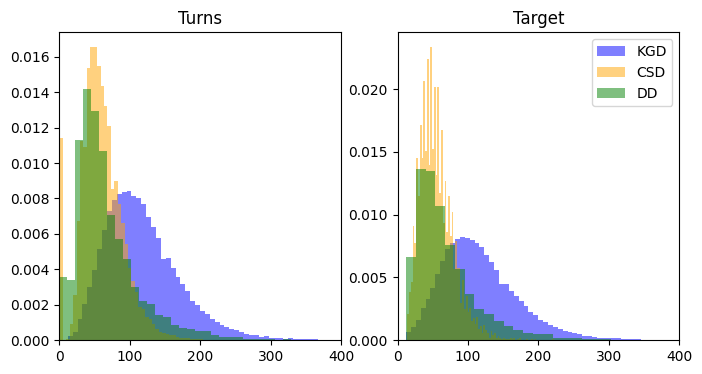

In [22]:
# plot length distributions of turns for each dataset

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(kgd_lengths['turns'], bins=100, alpha=0.5, label='KGD', color='blue', density=True)
axs[0].hist(csd_lengths['turns'], bins=100, alpha=0.5, label='CSD', color='orange', density=True)
axs[0].hist(dd_lengths['turns'], bins=100, alpha=0.5, label='DD', color='green', density=True)

axs[1].hist(kgd_lengths['target'], bins=100, alpha=0.5, label='KGD', color='blue', density=True)
axs[1].hist(csd_lengths['target'], bins=100, alpha=0.5, label='CSD', color='orange', density=True)
axs[1].hist(dd_lengths['target'], bins=100, alpha=0.5, label='DD', color='green', density=True)

axs[0].set_title('Turns')
axs[1].set_title('Target')
plt.legend()
axs[0].set_xlim(0, 400)
axs[1].set_xlim(0, 400)

plt.show();

In [ ]:
# def get_src_tgt_question_counts(example):
#     example['qus'] = count_questions(example['turns'] + [example['target']], verbose=False).tolist()
#     return example

# dataset = dataset.map(get_src_tgt_question_counts, batched=True, desc="Counting questions")
# print(dataset)
# print(dataset[0])
# # get_src_tgt_question_counts(dataset, '../resources/data/Topical-Chat/KGD/train_src_tgt_question_counts.csv')


# # def get_src_tgt_question_counts(dataset, outfile):
    
# #     with open(outfile, 'w', encoding='utf8') as f:
# #         for i, item in tqdm(enumerate(dataset)):
# #             result = count_questions(item['turns'] + [item['target']], verbose=False).tolist()
# #             # src_tgt_questions.append(result)
# #             f.write(f",".join(map(str, result)) + '\n')
# #             if i < 5:
# #                 print(result)
                
# #     print(f'Wrote {i+0} items to {outfile}')

# #     return
    
# # get_src_tgt_question_counts(dataset, '../resources/data/Topical-Chat/KGD/train_src_tgt_question_counts.csv')


In [13]:
# flattened_turns = flatten(dataset['test']['turns'][:20])
# flattened_turn_preds = classify_sentiment(flattened_turns, model_name="distilbert-base-uncased-finetuned-sst-2-english", batch_size=20)
# turn_preds = np.split(np.array([1 if x['label'] == 'POSITIVE' else 0 for x in flattened_turn_preds]), len(flattened_turn_preds)//len(dataset['test']['turns'][0]))
# turn_preds

# tgt_preds = classify_sentiment(dataset['test']['target'][:20], model_name="distilbert-base-uncased-finetuned-sst-2-english", batch_size=20)
# tgt_preds = np.array([1 if x['label'] == 'POSITIVE' else 0 for x in tgt_preds])
# tgt_preds



[0, 0, 0, 1, 1, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 4]

100%|██████████| 20/20 [00:00<00:00, 94466.31it/s]


array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0])

In [12]:
def is_question(text):
    if isinstance(text, list):
        return sum(list(map(is_question, text)))
    if '?' in text:
        return 1
    else:
        return 0

src_qus = np.array(list(map(is_question, dataset['test']['turns'])))
src_qus_ind = np.int64(src_qus > 0)
tgt_qus = np.array(list(map(is_question, dataset['test']['target'])))

In [94]:
print(pearsonr(src_qus,tgt_qus))
print(pearsonr(src_qus_ind,tgt_qus))

PearsonRResult(statistic=0.09551351159407137, pvalue=2.032077577753429e-291)
PearsonRResult(statistic=0.07832829958475114, pvalue=2.1735134661694424e-196)


In [22]:
print(dice(src_qus_ind,tgt_qus))
print(hamming(src_qus_ind,tgt_qus))
print(jaccard(src_qus_ind,tgt_qus))
print(jaccard(src_qus,tgt_qus))

0.5762186421770825
0.611726958509481
0.7311404988602418
0.9020383979196327


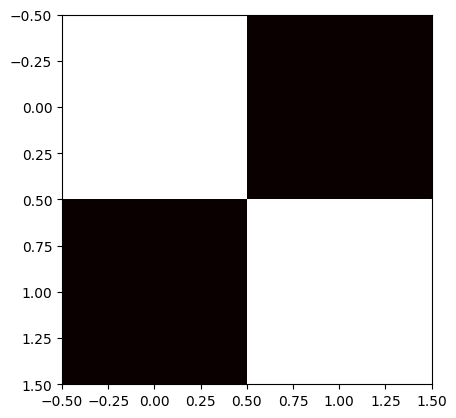

In [116]:
plt.imshow(np.corrcoef(src_qus,tgt_qus), cmap='hot', interpolation='nearest')

In [20]:
df = pd.DataFrame({'src': src_qus, 'tgt': tgt_qus})

In [21]:
df

,src,tgt
0,1,0
1,0,1
2,1,0
3,1,1
4,2,0
...,...,...
145233,1,0
145234,1,0
145235,1,1
145236,2,0


In [118]:
printdf['src'].corr(df['tgt'], method='spearman'))

0.09580578162897338

In [111]:
print(df['src'].describe())
print(df['tgt'].describe())

count    145238.000000
mean          1.506155
std           1.111722
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: src, dtype: float64
count    145238.000000
mean          0.264876
std           0.441268
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: tgt, dtype: float64


In [112]:
df['tgt'].sum()

38470

Regression line: y=0.21+0.04x, r=0.10


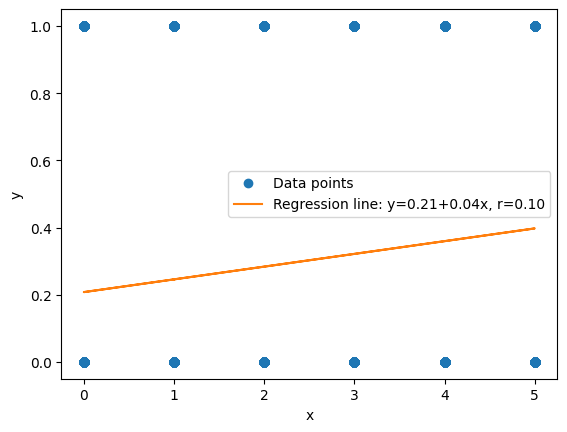

In [105]:
def plot(x, y):
    slope, intercept, r, p, stderr = linregress(x, y)
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    print(line)
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='o', label='Data points')
    ax.plot(x, intercept + slope * x, label=line)
    ax.set_xlabel('x')
    
    ax.set_ylabel('y')
    ax.legend(facecolor='white')
    
    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(min(y), max(y))
        
    plt.show()

plot(src_qus,tgt_qus)

# plot(src_qus_ind,tgt_qus)

In [78]:
print(src_qus.shape)
print(src_qus.mean())
print(src_qus)

(145238,)
1.5061554138724025


AttributeError: 'numpy.ndarray' object has no attribute 'mode'

In [75]:
print(tgt_qus)

[0 1 0 ... 1 0 0]
